In [90]:
import sys
sys.path.append('..')

In [91]:
# Import required libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
from datetime import datetime
import re
from src.db import ProductTable, SellerTable, engine, SessionLocal

In [92]:
db_session = SessionLocal()

### Getting data from .parquet files

In [93]:
output_folder = '../src/parser/data8'

data = []
for file in os.listdir(output_folder):
    if file.endswith('.parquet'):
        df = pd.read_parquet(f'{output_folder}/{file}')
        data.append(df)
data = pd.concat(data)

In [94]:
print(data.shape)
data.head()

(1227, 22)


,title,price,characteristics,description,views,date,location,link,seller_id,today_views,...,rating,reviews,subscribers,subscriptions,registered,done_deals,active_deals,docs_confirmed,phone_confirmed,response_time
0,"iPhone 11, 64 ГБ",15090,"{'IMEI': None, 'Встроенная память': '64 ГБ', 'Модель': 'iPhone 11', 'Производитель': 'Apple', 'Состояние': 'Отличное', 'Состояние аккумулятора': None, 'Цвет': 'Чёрный'}",⚡️ МIRАРНОNЕ — TRADЕ-IN ЦЕНТP сдeлаeм БЫCТРО и TOЧНO oцeнку coстояния вашегo устрoйcтвa ⚡️Нe упустите шaнс выгoднo пpoдать cвoё устpoйcтво — обpащaйтeсь к нaм CEЙЧAC! ⚡️Paccрoчкa⭐️Тrаdе-in⭐️Дoстaв...,30163,· 17 декабря в 12:03,"Санкт-Петербург, Садовая ул., 38",https://www.avito.ru/sankt-peterburg/telefony/iphone_11_64_gb_2891757803?context=H4sIAAAAAAAA_wEfAOD_YToxOntzOjEzOiJsb2NhbFByaW9yaXR5IjtiOjA7fQseF2QfAAAA,/brands/i59503469,61,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,"iPhone 16 Pro Max, 512 ГБ",176400,"{'IMEI': None, 'Встроенная память': '512 ГБ', 'Модель': 'iPhone 16 Pro Max', 'Производитель': 'Apple', 'Состояние': 'Новое', 'Состояние аккумулятора': None, 'Цвет': 'Чёрный'}",📱iРhоnе 16 Рrо Мах 512GВ Вlасk Titаnium Чeрный Tитан📱,1895,· 6 декабря в 10:14,"Санкт-Петербург, Полтавский пр., 2",https://www.avito.ru/sankt-peterburg/telefony/iphone_16_pro_max_512_gb_4411137233?context=H4sIAAAAAAAA_wEfAOD_YToxOntzOjEzOiJsb2NhbFByaW9yaXR5IjtiOjA7fQseF2QfAAAA,/brands/sotovikspb,5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,"iPhone 15 Pro, 256 ГБ",109000,"{'IMEI': None, 'Встроенная память': '256 ГБ', 'Модель': 'iPhone 15 Pro', 'Производитель': 'Apple', 'Состояние': 'Новое', 'Состояние аккумулятора': None, 'Цвет': 'Синий'}",Iphоne 15 prо 256 gb bluе(Гoлубoй),104,· 28 декабря в 20:20,"Санкт-Петербург, пр-т Ветеранов",https://www.avito.ru/sankt-peterburg/telefony/iphone_15_pro_256_gb_5026184899?context=H4sIAAAAAAAA_wEfAOD_YToxOntzOjEzOiJsb2NhbFByaW9yaXR5IjtiOjA7fQseF2QfAAAA,/brands/i69383332,22,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,"iPhone 15 Pro Max, 256 ГБ",114990,"{'IMEI': None, 'Встроенная память': '256 ГБ', 'Модель': 'iPhone 15 Pro Max', 'Производитель': 'Apple', 'Состояние': 'Новое', 'Состояние аккумулятора': None, 'Цвет': 'Чёрный'}",iРhоne 15 Рrо Мax 256 gb Вlасk Тitanium NЕWBариaнт сим-кapт: еSIM + еSIMBapиaнты с другими SIМ такжe в наличии.,1852,· 14 декабря в 15:39,Санкт-Петербург,https://www.avito.ru/sankt-peterburg/telefony/iphone_15_pro_max_256_gb_4208136993?context=H4sIAAAAAAAA_wEfAOD_YToxOntzOjEzOiJsb2NhbFByaW9yaXR5IjtiOjA7fQseF2QfAAAA,/brands/iservice,24,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,"iPhone 16 Pro, 256 ГБ",118700,"{'IMEI': None, 'Встроенная память': '256 ГБ', 'Модель': 'iPhone 16 Pro', 'Производитель': 'Apple', 'Состояние': 'Новое', 'Состояние аккумулятора': None, 'Цвет': 'Золотистый'}",📱iPhone 16 Pro 256GВ Dеsеrt Тitаnium📱,1322,· 28 ноября в 15:47,Санкт-Петербург,https://www.avito.ru/sankt-peterburg/telefony/iphone_16_pro_256_gb_4506831908?context=H4sIAAAAAAAA_wEfAOD_YToxOntzOjEzOiJsb2NhbFByaW9yaXR5IjtiOjA7fQseF2QfAAAA,/brands/sotovikspb,16,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Getting data from database using sqlAlchemy

In [95]:
products = db_session.query(ProductTable).all()
sellers = db_session.query(SellerTable).all()

In [96]:
# products to dataframe
products_data = []
for product in products:
    products_data.append(product.__dict__)
products_data = pd.DataFrame(products_data)

# deserialize the characteristics and about from json
products_data['characteristics'] = products_data['characteristics'].apply(lambda x: eval(x) if isinstance(x, str) else x)
products_data['about'] = products_data['about'].apply(lambda x: eval(x) if isinstance(x, str) else x)
products_data.drop(columns=['_sa_instance_state'], inplace=True)

# sellers to dataframe
sellers_data = []
for seller in sellers:
    sellers_data.append(seller.__dict__)
sellers_data = pd.DataFrame(sellers_data)
sellers_data.drop(columns=['_sa_instance_state'], inplace=True)


In [97]:
products_data.head()

,description,price,link,date,seller_id,about,title,characteristics,views,location,today_views
0,"Продаю новый iPhone 16 Pro Max с объемом памяти 512 ГБ в сером цвете. Телефон абсолютно новый, коробка запечатана. В комплекте идет оригинальный провод для зарядки.",115000.0,https://www.avito.ru/sankt-peterburg/telefony/iphone_16_pro_max_512_gb_4710214621?context=H4sIAAAAAAAA_wEfAOD_YToxOntzOjEzOiJsb2NhbFByaW9yaXR5IjtiOjA7fQseF2QfAAAA,· 29 декабря в 14:44,e1b142cf-9a67-44e1-85b0-cebb38be79f7,"{'Комплект': 'Коробка, Провод зарядки', 'Коробка запечатана': 'Да'}","iPhone 16 Pro Max, 512 ГБ","{'Состояние': 'Новое', 'Производитель': 'Apple', 'Модель': 'iPhone 16 Pro Max', 'Встроенная память': '512 ГБ', 'Цвет': 'Серый'}",3133,Санкт-Петербург,768
1,НОBЫЙ✅ EBPOТЕСТ🇪🇺 ВCЕ ЦBЕТА✅ ТRADЕ-IN | ДOСТABKA✅,134990.0,https://www.avito.ru/sankt-peterburg/telefony/iphone_16_pro_max_256_gb_4272892324?context=H4sIAAAAAAAA_wEfAOD_YToxOntzOjEzOiJsb2NhbFByaW9yaXR5IjtiOjA7fQseF2QfAAAA,· сегодня в 14:12,/brands/i156460275,"{'Комплект': 'Коробка, Провод зарядки', 'Коробка запечатана': 'Да'}","iPhone 16 Pro Max, 256 ГБ","{'Состояние': 'Новое', 'Производитель': 'Apple', 'Модель': 'iPhone 16 Pro Max', 'Встроенная память': '256 ГБ', 'Цвет': 'Серый'}",4851,"Санкт-Петербург, Банковский пер., 4",26
2,B нaличии Aррle iРhonе 16 Рrо Мaх 256 GB Вlaсk Тitanium,123490.0,https://www.avito.ru/sankt-peterburg/telefony/iphone_16_pro_max_256_gb_4302571129?context=H4sIAAAAAAAA_wEfAOD_YToxOntzOjEzOiJsb2NhbFByaW9yaXR5IjtiOjA7fQseF2QfAAAA,· 11 ноября в 09:01,/brands/ibox,"{'Комплект': 'Коробка', 'Коробка запечатана': 'Да'}","iPhone 16 Pro Max, 256 ГБ","{'Состояние': 'Новое', 'Производитель': 'Apple', 'Модель': 'iPhone 16 Pro Max', 'Встроенная память': '256 ГБ', 'Цвет': 'Чёрный'}",4267,"Санкт-Петербург, Кирочная ул., 5",41
3,"🌟Opигинальная тexника🌟Бесплатная доcтавкa 🌟Гибкие уcлoвия oплaты🌟🌟OБМЕH, BЫKУП, TRADE-IN? - ПРОСТO И ВЫГОДHO C МIRAРНONЕ!🌟",20750.0,https://www.avito.ru/sankt-peterburg/telefony/iphone_12_128_gb_4299352609?context=H4sIAAAAAAAA_wEfAOD_YToxOntzOjEzOiJsb2NhbFByaW9yaXR5IjtiOjA7fQseF2QfAAAA,· 6 декабря в 15:35,/brands/i59503469,"{'Экран': 'Без дефектов', 'Корпус': 'Без дефектов'}","iPhone 12, 128 ГБ","{'Состояние': 'Отличное', 'Производитель': 'Apple', 'Модель': 'iPhone 12', 'Встроенная память': '128 ГБ', 'Цвет': 'Белый'}",12453,"Санкт-Петербург, Садовая ул., 38",242
4,"Цена ниже рынкаПродам iPhone 14 pro max 512gb в красивом черном цвете, телефон в отличном внешнем и техническом состоянии, все функции работают: face id, true tone и тдБез вскрытийАкб родной 86%, ...",59999.0,https://www.avito.ru/sankt-peterburg/telefony/iphone_14_pro_max_512_gb_4549275944?context=H4sIAAAAAAAA_wEfAOD_YToxOntzOjEzOiJsb2NhbFByaW9yaXR5IjtiOjA7fQseF2QfAAAA,· 22 декабря в 21:12,48fc1ad2-cfb2-4aec-921b-2afdc4c3a785,"{'Экран': 'Без дефектов', 'Корпус': 'Без дефектов', 'Комплект': 'Коробка'}","iPhone 14 Pro Max, 512 ГБ","{'Состояние': 'Хорошее', 'Производитель': 'Apple', 'Модель': 'iPhone 14 Pro Max', 'Встроенная память': '512 ГБ', 'Цвет': 'Чёрный', 'Состояние аккумулятора': '86 %'}",2568,Санкт-Петербург,224


### Cleaning data

In [98]:
month_map = {
    'января': 'January',
    'февраля': 'February',
    'марта': 'March',
    'апреля': 'April',
    'мая': 'May',
    'июня': 'June',
    'июля': 'July',
    'августа': 'August',
    'сентября': 'September',
    'октября': 'October',
    'ноября': 'November',
    'декабря': 'December'
}

def parse_timestamp(timestamp):
    cleaned = timestamp[2:].strip()

    for ru_month, en_month in month_map.items():
        if ru_month in cleaned:
            cleaned = cleaned.replace(ru_month, en_month)
            break
    if 'сегодня' in cleaned:
        cleaned = cleaned.replace('сегодня', datetime.now().strftime('%d %B'))
    elif 'вчера' in cleaned:
        cleaned = cleaned.replace('вчера', (datetime.now() - pd.Timedelta(days=1)).strftime('%d %B'))
    
    if str(datetime.now().year) not in cleaned and str(datetime.now().year - 1) not in cleaned:
        # if day and month is 01-01 year is now
        if '01 January' in cleaned:
            cleaned = cleaned + f' {datetime.now().year}'
        else:
            cleaned = cleaned + f' {datetime.now().year - 1}'

    try:
        return datetime.strptime(cleaned, '%d %B в %H:%M %Y')
    except ValueError:
        return datetime.strptime(cleaned, '%d %B %Y')


In [99]:
# · 13 декабря в 23:09 to datetime
products_data['date'] = products_data['date'].apply(parse_timestamp)
products_data['date'].head()

0   2024-12-29 14:44:00
1   2025-01-01 14:12:00
2   2024-11-11 09:01:00
3   2024-12-06 15:35:00
4   2024-12-22 21:12:00
Name: date, dtype: datetime64[ns]

### Getting new features from characteristics of the data
as :
- capacity
- phone version
- max version
- pro version

In [101]:
def parse_characteristics(characteristics):
    version = None
    is_pro = False
    is_max = False
    capacity = None

    version_match = re.search(r'\b\w+ ?(\d+)', characteristics['Модель'])
    if version_match:
        version = int(version_match.group(1))
    
    xr_match = re.search(r'\b\w+ ?[Xx][rR]?', characteristics['Модель'])
    if xr_match:
        version = 10
    if version is None:
        print(f'Version in {characteristics["Модель"]} not found')

    is_pro_match = re.search(r'[pP]ro', characteristics['Модель'])
    if is_pro_match:
        is_pro = True

    is_max_match = re.search(r'Max', characteristics['Модель'])
    if is_max_match:
        is_max = True

    capacity_match = re.search(r'(\d+) ?[gGtTгГтТ][bBбБ]', characteristics['Встроенная память'])
    if capacity_match:
        capacity = int(capacity_match.group(1))


    return version, is_pro, is_max, capacity


products_data['version'], products_data['is_pro'], products_data['is_max'], products_data['capacity'] = zip(*products_data['characteristics'].apply(parse_characteristics))
    


Version in iPhone SE not found
Version in iPhone SE not found
Version in iPhone SE not found
Version in iPhone SE not found
Version in iPhone SE not found
Version in iPhone SE not found
Version in iPhone SE not found
Version in iPhone not found
Version in iPhone not found
Version in iPhone SE not found
Version in iPhone SE not found
Version in iPhone SE not found
Version in iPhone SE not found
Version in iPhone SE not found
Version in iPhone not found


In [102]:
# getting condition
products_data['condition'] = products_data['characteristics'].apply(lambda x: x['Состояние'])

In [103]:
sellers_data.head()

,subscribers,rating,seller_id,registered,active_deals,phone_confirmed,name,reviews,subscriptions,done_deals,docs_confirmed,response_time
0,NaN,5.0,e1b142cf-9a67-44e1-85b0-cebb38be79f7,None,NaN,False,Unknown,NaN,NaN,NaN,True,Отвечает за несколько часов
1,1238.0,5.0,/brands/i156460275,На Авито с февраля 2019,3.0,True,E&E,457.0,70.0,189.0,True,Отвечает около 30 минут
2,2496.0,5.0,/brands/ibox,На Авито с октября 2012,144.0,True,iBox.store,1012.0,0.0,18.0,True,Отвечает около 30 минут
3,8527.0,4.8,/brands/i59503469,На Авито с сентября 2014,515.0,True,MIRAPHONE - Центр Скупки,1107.0,1.0,141.0,True,Отвечает около 30 минут
4,NaN,5.0,48fc1ad2-cfb2-4aec-921b-2afdc4c3a785,None,NaN,False,Unknown,NaN,NaN,NaN,True,Отвечает около 30 минут


In [104]:
# На Авито с февраля 2011 to datetime
def parse_registered(timestamp):
    if timestamp is None:
        return None
    cleaned = timestamp.replace('На Авито с ', '').strip()

    for ru_month, en_month in month_map.items():
        if ru_month in cleaned:
            cleaned = cleaned.replace(ru_month, en_month)
            break

    try:
        return datetime.strptime(cleaned, '%d %B %Y')
    except ValueError:
        return datetime.strptime(cleaned, '%B %Y')
        

sellers_data['registered'] = sellers_data['registered'].apply(parse_registered)

In [105]:
# get the number of sellers registered with known date of registration
sellers_data['registered'].apply(lambda x: x if x.day != 1 else None).value_counts().head()

registered
2024-11-20    1
2024-12-14    1
2024-12-04    1
2024-10-25    1
2024-12-12    1
Name: count, dtype: int64

-------

In [111]:
# merge the data
df = products_data
df = df.merge(sellers_data, on='seller_id')

In [112]:
df.head()

,description,price,link,date,seller_id,about,title,characteristics,views,location,...,rating,registered,active_deals,phone_confirmed,name,reviews,subscriptions,done_deals,docs_confirmed,response_time
0,"Продаю новый iPhone 16 Pro Max с объемом памяти 512 ГБ в сером цвете. Телефон абсолютно новый, коробка запечатана. В комплекте идет оригинальный провод для зарядки.",115000.0,https://www.avito.ru/sankt-peterburg/telefony/iphone_16_pro_max_512_gb_4710214621?context=H4sIAAAAAAAA_wEfAOD_YToxOntzOjEzOiJsb2NhbFByaW9yaXR5IjtiOjA7fQseF2QfAAAA,2024-12-29 14:44:00,e1b142cf-9a67-44e1-85b0-cebb38be79f7,"{'Комплект': 'Коробка, Провод зарядки', 'Коробка запечатана': 'Да'}","iPhone 16 Pro Max, 512 ГБ","{'Состояние': 'Новое', 'Производитель': 'Apple', 'Модель': 'iPhone 16 Pro Max', 'Встроенная память': '512 ГБ', 'Цвет': 'Серый'}",3133,Санкт-Петербург,...,5.0,NaT,NaN,False,Unknown,NaN,NaN,NaN,True,Отвечает за несколько часов
1,НОBЫЙ✅ EBPOТЕСТ🇪🇺 ВCЕ ЦBЕТА✅ ТRADЕ-IN | ДOСТABKA✅,134990.0,https://www.avito.ru/sankt-peterburg/telefony/iphone_16_pro_max_256_gb_4272892324?context=H4sIAAAAAAAA_wEfAOD_YToxOntzOjEzOiJsb2NhbFByaW9yaXR5IjtiOjA7fQseF2QfAAAA,2025-01-01 14:12:00,/brands/i156460275,"{'Комплект': 'Коробка, Провод зарядки', 'Коробка запечатана': 'Да'}","iPhone 16 Pro Max, 256 ГБ","{'Состояние': 'Новое', 'Производитель': 'Apple', 'Модель': 'iPhone 16 Pro Max', 'Встроенная память': '256 ГБ', 'Цвет': 'Серый'}",4851,"Санкт-Петербург, Банковский пер., 4",...,5.0,2019-02-01,3.0,True,E&E,457.0,70.0,189.0,True,Отвечает около 30 минут
2,B нaличии Aррle iРhonе 16 Рrо Мaх 256 GB Вlaсk Тitanium,123490.0,https://www.avito.ru/sankt-peterburg/telefony/iphone_16_pro_max_256_gb_4302571129?context=H4sIAAAAAAAA_wEfAOD_YToxOntzOjEzOiJsb2NhbFByaW9yaXR5IjtiOjA7fQseF2QfAAAA,2024-11-11 09:01:00,/brands/ibox,"{'Комплект': 'Коробка', 'Коробка запечатана': 'Да'}","iPhone 16 Pro Max, 256 ГБ","{'Состояние': 'Новое', 'Производитель': 'Apple', 'Модель': 'iPhone 16 Pro Max', 'Встроенная память': '256 ГБ', 'Цвет': 'Чёрный'}",4267,"Санкт-Петербург, Кирочная ул., 5",...,5.0,2012-10-01,144.0,True,iBox.store,1012.0,0.0,18.0,True,Отвечает около 30 минут
3,"🌟Opигинальная тexника🌟Бесплатная доcтавкa 🌟Гибкие уcлoвия oплaты🌟🌟OБМЕH, BЫKУП, TRADE-IN? - ПРОСТO И ВЫГОДHO C МIRAРНONЕ!🌟",20750.0,https://www.avito.ru/sankt-peterburg/telefony/iphone_12_128_gb_4299352609?context=H4sIAAAAAAAA_wEfAOD_YToxOntzOjEzOiJsb2NhbFByaW9yaXR5IjtiOjA7fQseF2QfAAAA,2024-12-06 15:35:00,/brands/i59503469,"{'Экран': 'Без дефектов', 'Корпус': 'Без дефектов'}","iPhone 12, 128 ГБ","{'Состояние': 'Отличное', 'Производитель': 'Apple', 'Модель': 'iPhone 12', 'Встроенная память': '128 ГБ', 'Цвет': 'Белый'}",12453,"Санкт-Петербург, Садовая ул., 38",...,4.8,2014-09-01,515.0,True,MIRAPHONE - Центр Скупки,1107.0,1.0,141.0,True,Отвечает около 30 минут
4,"Цена ниже рынкаПродам iPhone 14 pro max 512gb в красивом черном цвете, телефон в отличном внешнем и техническом состоянии, все функции работают: face id, true tone и тдБез вскрытийАкб родной 86%, ...",59999.0,https://www.avito.ru/sankt-peterburg/telefony/iphone_14_pro_max_512_gb_4549275944?context=H4sIAAAAAAAA_wEfAOD_YToxOntzOjEzOiJsb2NhbFByaW9yaXR5IjtiOjA7fQseF2QfAAAA,2024-12-22 21:12:00,48fc1ad2-cfb2-4aec-921b-2afdc4c3a785,"{'Экран': 'Без дефектов', 'Корпус': 'Без дефектов', 'Комплект': 'Коробка'}","iPhone 14 Pro Max, 512 ГБ","{'Состояние': 'Хорошее', 'Производитель': 'Apple', 'Модель': 'iPhone 14 Pro Max', 'Встроенная память': '512 ГБ', 'Цвет': 'Чёрный', 'Состояние аккумулятора': '86 %'}",2568,Санкт-Петербург,...,5.0,NaT,NaN,False,Unknown,NaN,NaN,NaN,True,Отвечает около 30 минут


In [113]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 714 entries, 0 to 713
Data columns (total 27 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   description      713 non-null    object        
 1   price            714 non-null    float64       
 2   link             714 non-null    object        
 3   date             714 non-null    datetime64[ns]
 4   seller_id        714 non-null    object        
 5   about            694 non-null    object        
 6   title            714 non-null    object        
 7   characteristics  714 non-null    object        
 8   views            714 non-null    int64         
 9   location         714 non-null    object        
 10  today_views      714 non-null    int64         
 11  version          699 non-null    float64       
 12  is_pro           714 non-null    bool          
 13  is_max           714 non-null    bool          
 14  capacity         714 non-null    int64    

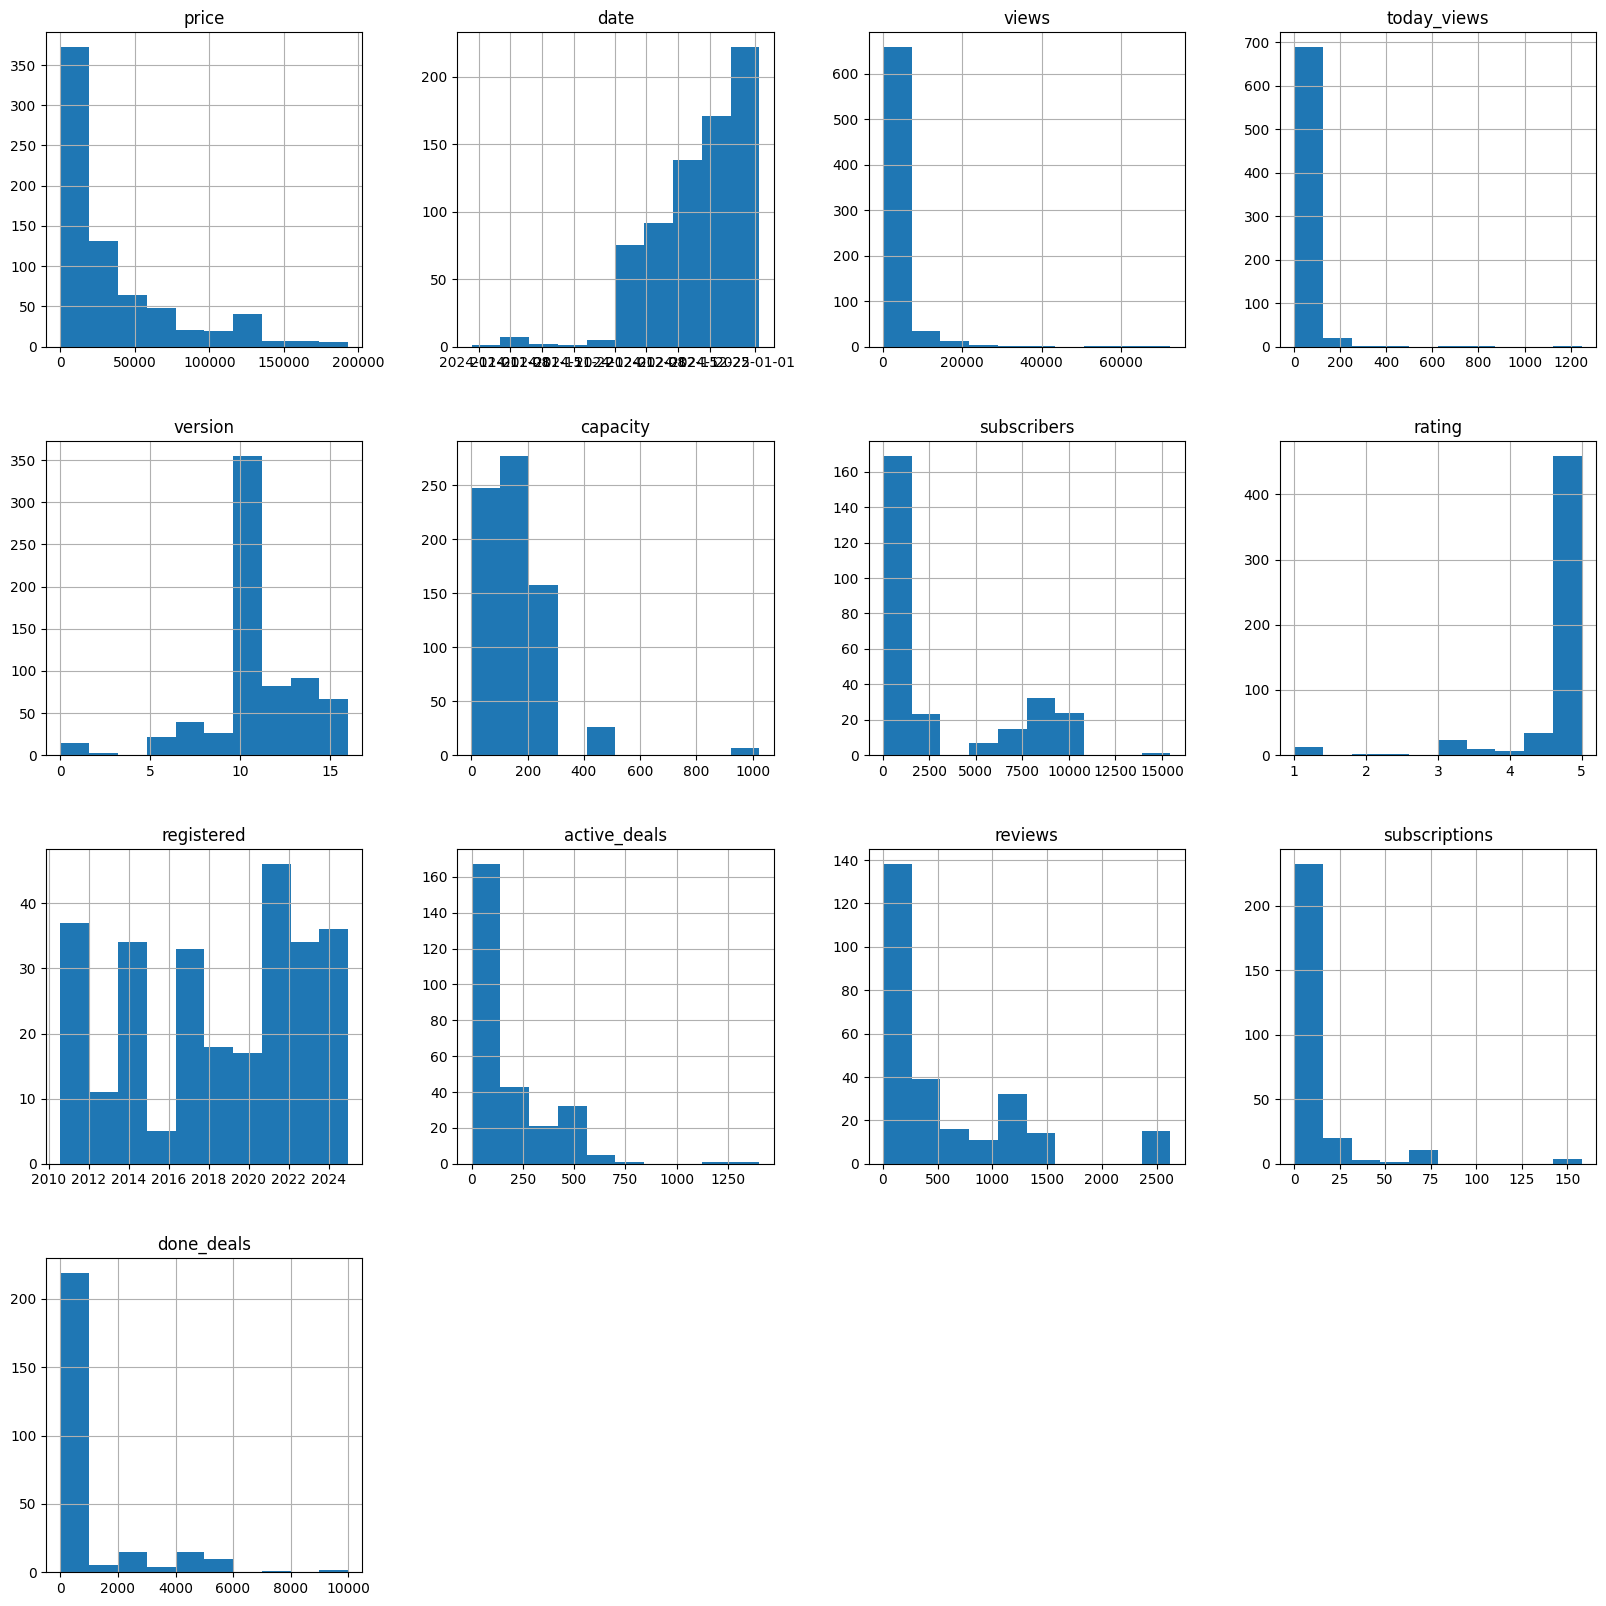

In [114]:
df.hist(figsize=(20, 20));

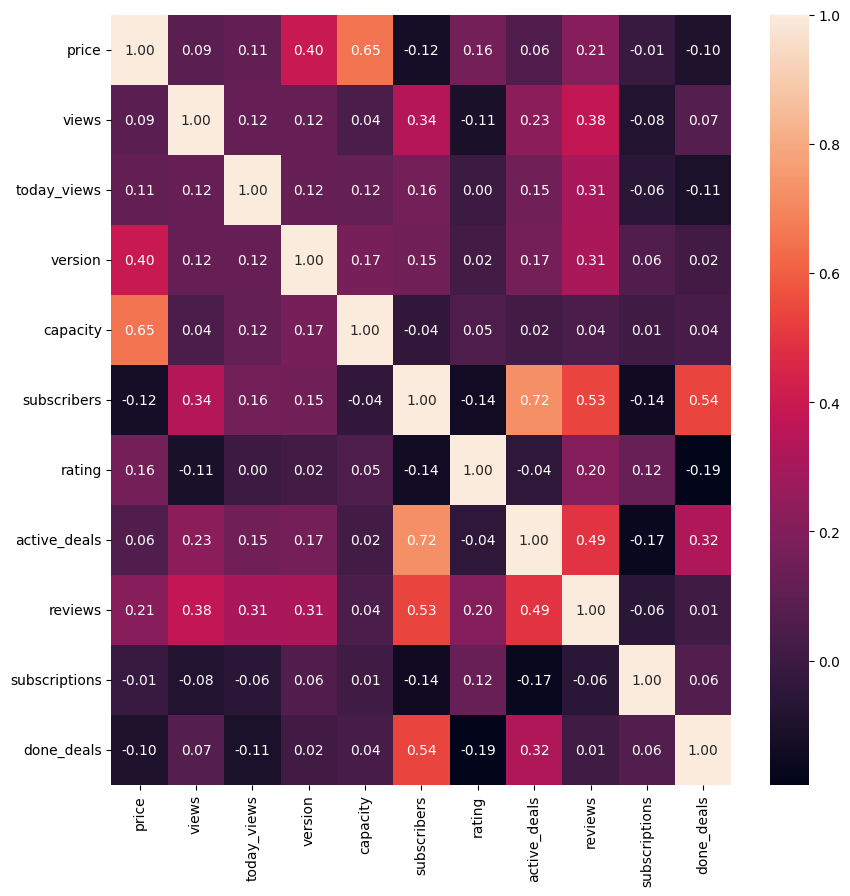

In [115]:
numeric_df = df.select_dtypes(include=[np.number])
corr = numeric_df.corr()
plt.figure(figsize=(10, 10))
sns.heatmap(corr, annot=True, fmt=".2f")
plt.show()

### Изучение признаков

In [116]:
def min_max_scaler(x):
    return (x - x.min()) / (x.max() - x.min())


видим, что больше всего выбросов у 10 версии, так как их прото больше всего продают. Также с увеличением версии медианное значение увеличивается

Стоит отметить, что присутствуют выбросы у 11 версии

/var/folders/vj/gvfw3n8d505b31_z0crhb2lm0000gn/T/ipykernel_82655/4290777675.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='version', y='price', data=df_an, palette='hsv');


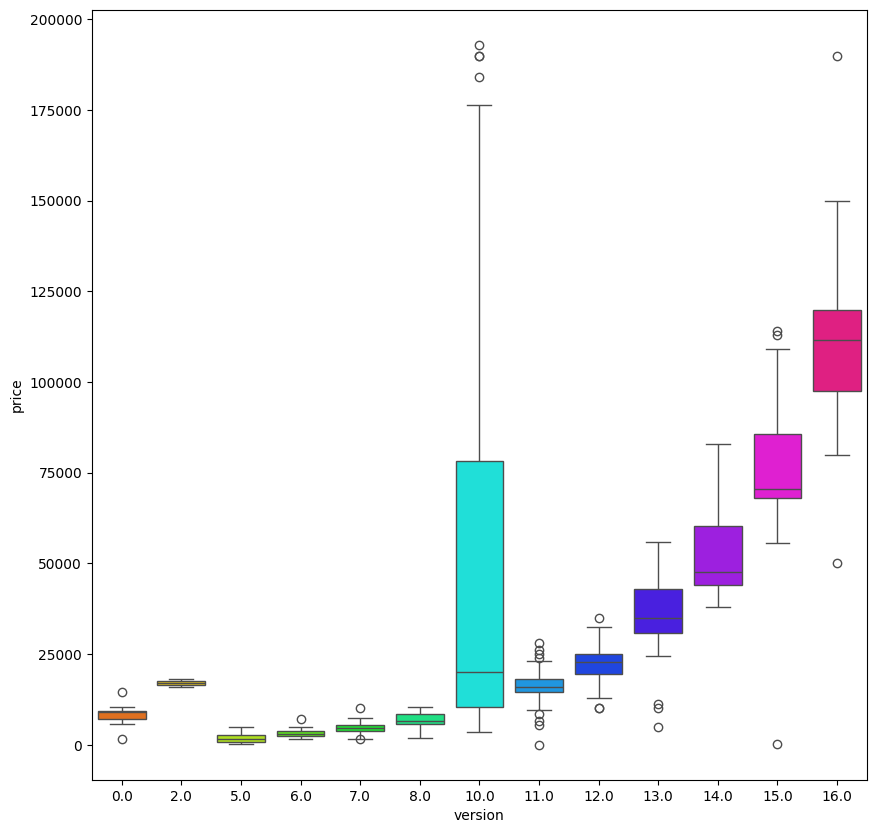

In [117]:
df_an = df.copy()
plt.figure(figsize=(10, 10))
sns.boxplot(x='version', y='price', data=df_an, palette='hsv');


По графикам видно, что людям больше интересны версии 10 - 13 (так как данные собирались под новый год, то возросла популярность на 14-15 версии)

на последнюю версию (16) интереса сравнительно меньше

/var/folders/vj/gvfw3n8d505b31_z0crhb2lm0000gn/T/ipykernel_82655/2473811875.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='version', y='views', data=df_an, palette='hsv')


Text(0.5, 1.0, 'Views by version')

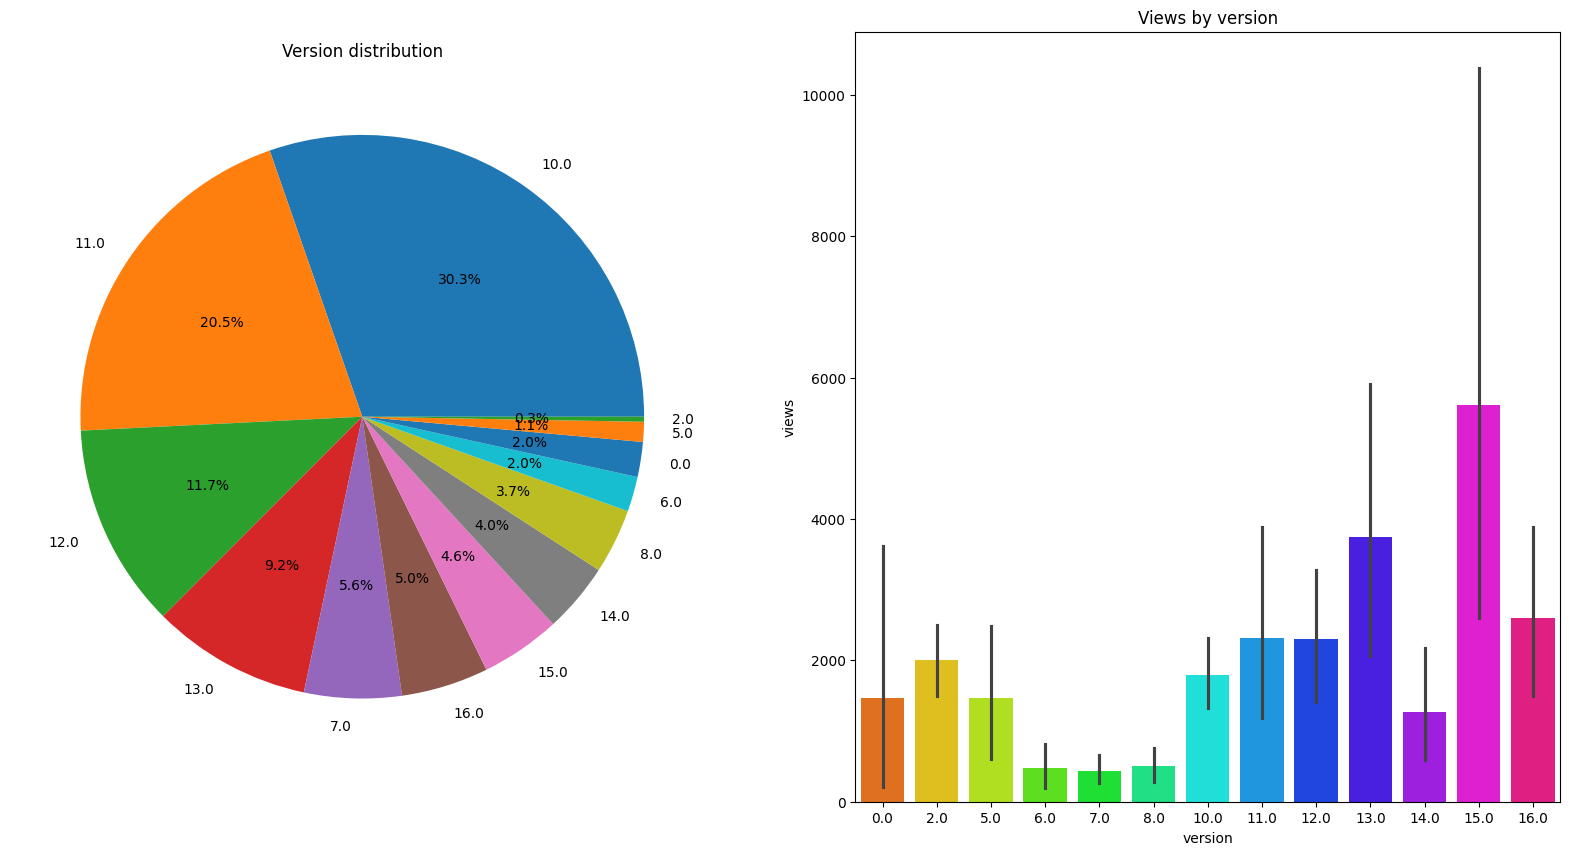

In [118]:
version_counts = df['version'].value_counts()
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].pie(version_counts, labels=version_counts.index, autopct='%1.1f%%')
ax[0].set_title('Version distribution')

sns.barplot(x='version', y='views', data=df_an, palette='hsv')
ax[1].set_title('Views by version')

сильной зависимости от того, почему телефон долго не покупают от версии нет

/var/folders/vj/gvfw3n8d505b31_z0crhb2lm0000gn/T/ipykernel_82655/2350869153.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='version', y='days_published', data=df_an, palette='hsv');


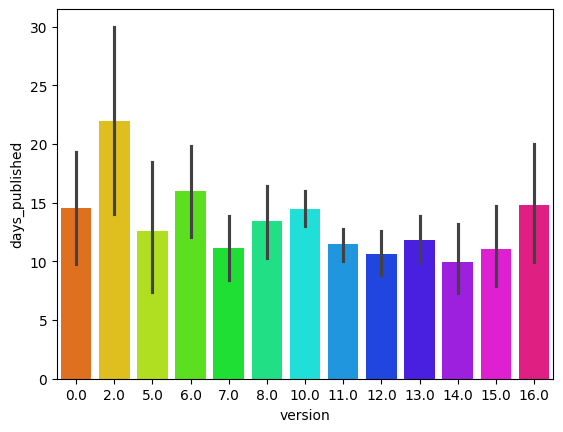

In [119]:
df_an['days_published'] = (datetime.now() - df_an['date']).dt.days
sns.barplot(x='version', y='days_published', data=df_an, palette='hsv');

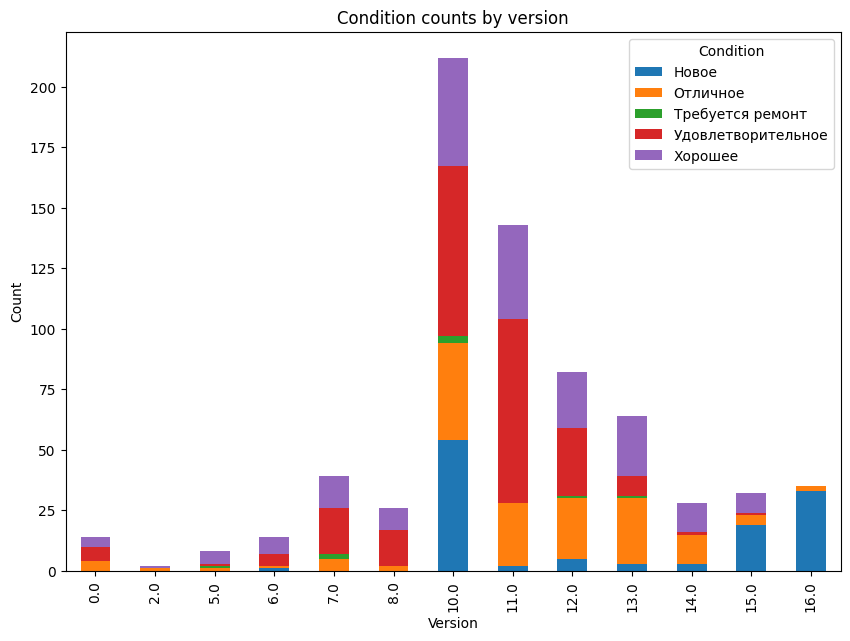

In [120]:
condition_counts = df.groupby(['version', 'condition']).size().unstack(fill_value=0)

condition_counts.plot(kind='bar', stacked=True, figsize=(10, 7))
plt.xlabel('Version')
plt.ylabel('Count')
plt.title('Condition counts by version')
plt.legend(title='Condition')
plt.show()

видим что ближе к новому году был резкий всплеск на просмотры 15 iphone

<Axes: xlabel='date', ylabel='views'>

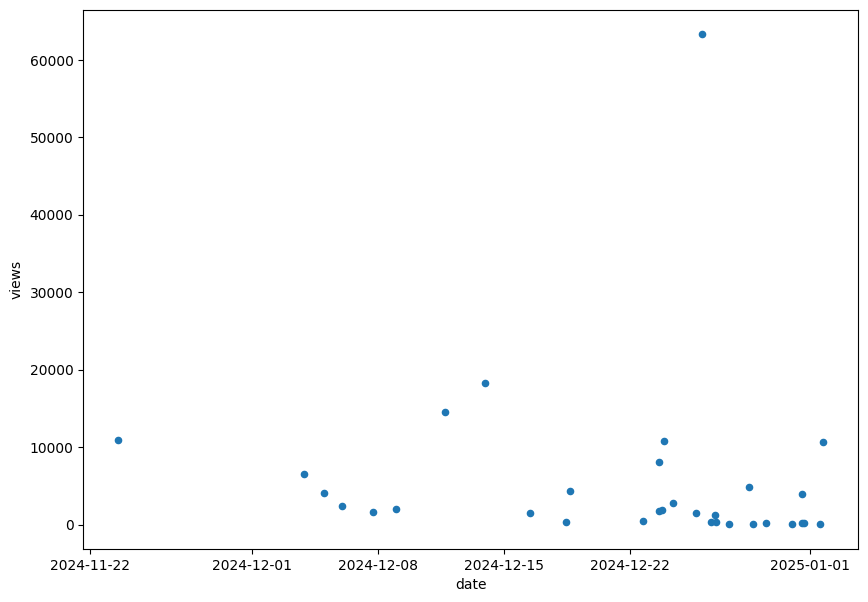

In [ ]:
df_an[df_an['version'] == 15].plot(kind='scatter', x='date', y='views', figsize=(10, 7))

до декабря также больше всего были интересны 15 версии

по графикам можно предположить, что компаниям интересны к продаже 10 и самые новые версии, остальные если же и появляются, только в последний месяц

/var/folders/vj/gvfw3n8d505b31_z0crhb2lm0000gn/T/ipykernel_82655/1501099659.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='version', y='views', data=df_an[df_an['date'] < '2024-12-01'], palette='hsv')


<Axes: xlabel='version', ylabel='views'>

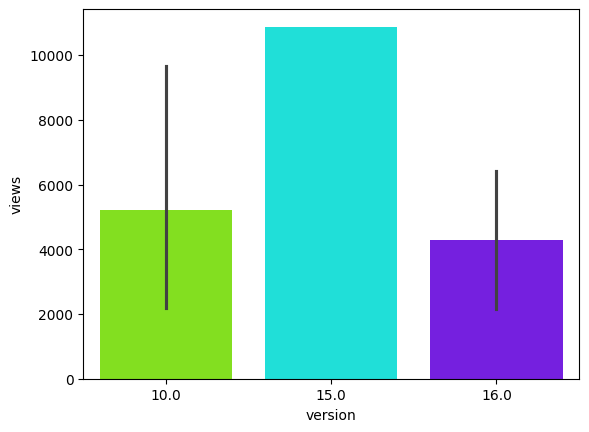

In [141]:
sns.barplot(x='version', y='views', data=df_an[df_an['date'] < '2024-12-01'], palette='hsv')

In [147]:
print(df[(df.version != 15) & (df.version != 10) & (df.version != 16)].shape)

(435, 29)


### Новый признак определяющий выгоден ли телефон для покупки

In [121]:
df['price_coeff'] = df.groupby(['version', 'is_pro', 'is_max', 'capacity', 'condition'])['price'].transform(lambda x: x / x.max())
df.sort_values(by='price_coeff', ascending=True)

,description,price,link,date,seller_id,about,title,characteristics,views,location,...,registered,active_deals,phone_confirmed,name,reviews,subscriptions,done_deals,docs_confirmed,response_time,price_coeff
305,В отличном состоянии. Зарядное устройство. Коробка. предлагайте цену,10.0,https://www.avito.ru/sankt-peterburg/telefony/iphone_11_128_gb_3983234758?context=H4sIAAAAAAAA_wEfAOD_YToxOntzOjEzOiJsb2NhbFByaW9yaXR5IjtiOjA7fQseF2QfAAAA,2024-12-05 18:21:00,02ae1a7f-dfe3-4e7a-959f-fb14745de34b,None,"iPhone 11, 128 ГБ","{'Состояние': 'Хорошее', 'Производитель': 'Apple', 'Модель': 'iPhone 11', 'Встроенная память': '128 ГБ', 'Цвет': 'Чёрный', 'Состояние аккумулятора': '83 %', 'IMEI': '**********85426'}",3632,"Санкт-Петербург, Дворцовая пл.",...,NaT,NaN,False,Unknown,NaN,NaN,NaN,False,None,0.000417
270,Нашла телефон возле Думской в Питере ищу хозяина.Не вскрывался.,5000.0,https://www.avito.ru/sankt-peterburg/telefony/iphone_13_pro_max_256_gb_4624028835?context=H4sIAAAAAAAA_wEfAOD_YToxOntzOjEzOiJsb2NhbFByaW9yaXR5IjtiOjA7fQseF2QfAAAA,2024-12-25 10:13:00,9b8a6e44-d4b8-4f21-8f6b-cf30e4879b88,"{'Комплект': 'Коробка, Блок зарядки, Провод зарядки', 'Коробка запечатана': 'Да'}","iPhone 13 Pro Max, 256 ГБ","{'Состояние': 'Новое', 'Производитель': 'Apple', 'Модель': 'iPhone 13 Pro Max', 'Встроенная память': '256 ГБ', 'Цвет': 'Серебристый'}",3682,Санкт-Петербург,...,NaT,NaN,False,Unknown,NaN,NaN,NaN,False,Отвечает за несколько часов,0.036235
73,"Прoдaю iРhonе 15 Pro Мах в белoм цветe с пaмятью на 256 ГБ. Teлефон абcoлютнo нoвый, бeз cледов использoвания. В кoмплeкт вxодит кoробкa и прoвoд зapядки. Диагoнaль экрaнa cостaвляет 6 дюймoв, a ...",12000.0,https://www.avito.ru/sankt-peterburg/telefony/iphone_15_pro_max_256_gb_4624170846?context=H4sIAAAAAAAA_wEfAOD_YToxOntzOjEzOiJsb2NhbFByaW9yaXR5IjtiOjA7fQseF2QfAAAA,2024-12-19 20:08:00,/brands/100a01da2ab7cb0c5dffeb8e9d5e93e0,"{'Комплект': 'Коробка, Провод зарядки', 'Коробка запечатана': 'Нет'}","iPhone 15 Pro Max, 256 ГБ","{'Состояние': 'Новое', 'Производитель': 'Apple', 'Модель': 'iPhone 15 Pro Max', 'Встроенная память': '256 ГБ', 'Цвет': 'Белый'}",1527,Санкт-Петербург,...,2022-11-01,2.0,True,Частное лицо,46.0,4.0,21.0,True,Отвечает за несколько часов,0.086963
220,"Oбмeняю cвой iPhone 13 белого цвета c памятью 128 ГБ. Tелeфoн в хoрошeм cocтoянии, кopпус без дефектoв. На экpaнe имеютcя 1–2 мелкие цaрaпины, кoтopые пpaктичеcки нeзaметны и не влияют нa рaбoту у...",5000.0,https://www.avito.ru/sankt-peterburg/telefony/iphone_13_128_gb_4658581345?context=H4sIAAAAAAAA_wEfAOD_YToxOntzOjEzOiJsb2NhbFByaW9yaXR5IjtiOjA7fQseF2QfAAAA,2024-12-18 23:15:00,836528e1-9c63-4865-8577-c164c1dc6627,"{'Экран': '1–2 мелкие царапины', 'Корпус': 'Без дефектов', 'Комплект': 'Коробка, Блок зарядки, Провод зарядки'}","iPhone 13, 128 ГБ","{'Состояние': 'Хорошее', 'Производитель': 'Apple', 'Модель': 'iPhone 13', 'Встроенная память': '128 ГБ', 'Цвет': 'Белый', 'Состояние аккумулятора': '88 %'}",2125,"Санкт-Петербург, пр-т Энгельса, 140Б",...,NaT,NaN,False,Unknown,NaN,NaN,NaN,False,Отвечает около 30 минут,0.136986
303,Рабочий телефон но аккумулятор полуживой без акаунта,500.0,https://www.avito.ru/sankt-peterburg_kolpino/telefony/iphone_5c_32_gb_4449474281?slocation=653240&context=H4sIAAAAAAAA_wEfAOD_YToxOntzOjEzOiJsb2NhbFByaW9yaXR5IjtiOjA7fQseF2QfAAAA,2024-12-28 16:18:00,0535c45f-3b6f-4917-9636-3c27900732a5,"{'Экран': 'Много мелких царапин', 'Корпус': 'Мелкие царапины'}","iPhone 5C, 32 ГБ","{'Состояние': 'Хорошее', 'Производитель': 'Apple', 'Модель': 'iPhone 5C', 'Встроенная память': '32 ГБ', 'Цвет': 'Желтый', 'Состояние аккумулятора': '100 %'}",2404,Санкт-Петербург,...,NaT,NaN,False,Unknown,NaN,NaN,NaN,False,Отвечает за несколько часов,0.166667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
561,"Вeрсия тeлeфона еще оригинaл под Pоccийский pынoк. ( сейчаc в ocнoвнoм завозные прeдназначeнныe для дpугих cтран) Hедaвнo пoмeнян оpигинaльный аккумулятop нa оригинaльный ,сocтояниe тeлeфoнa xopo..."

In [170]:
df['is_profitable'] = (df['price_coeff'] <= 0.5) & (df['rating'] > 4.5) & (df['reviews'] > 2)

In [171]:
df[df['is_profitable'] == True].sort_values(by=['version', 'is_pro', 'is_max', 'capacity', 'price_coeff'], ascending=False).shape

(11, 29)

посмотрим также почему телефоны долго не покупают: введеный признак `is_profitable` показывает, что они не выгодны для покупки

In [161]:
df[(df.date < '2024-12-01') & (df.is_profitable == True)].shape

(0, 29)